In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Tutorial on the Expectation-Maximization-algorithm with Gaussian mixture models

This tutorial derives the Expectation-Maximization (EM) algorithm in Gaussian mixture model (GMM) case. In addition to the derivation a practical Python implementation is provided for the reader to code the EM-algorithm by themselves without machine learning libraries.  


### Definitions

Let $\mathcal{X}=(\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_n)$ be a sample ($\textbf{x}_i\in \mathbb{R}^d$) of $n$ i.i.d. observations from a mixture of two distinct $d$-dimensional multivariate Gaussian distributions. Let $\mathcal{Y} = (y_1, y_2, ..., y_n)$ be the set of group labels, that is $y\in\{1,2\}$ which indicate from which Gaussian mixture each observation $\textbf{x}_i$ was truly sampled from. The set $\mathcal{Y}$ is sometimes called "latent" indicating that the gourp labels $y_i$ are unknown beforehand. That is, we do not know into which Gaussians the samples belong to. Furthermore, we define $\boldsymbol\theta = (\boldsymbol\tau, \boldsymbol\mu_1, \boldsymbol\mu_2, \boldsymbol\Sigma_1, \boldsymbol\Sigma_2)$ to be a set of parameters which fully describe the distributions of the data. The parameters $\boldsymbol\tau = (\tau_1, \tau_2)$ are the "mixing parameters" with $\tau_1+\tau_2 = 1$ which determine the weights of "how much" each sample $\textbf{x}_i$ came from either Gaussian. We treat these "mixing values" as the prior probabilities that a given sample $\textbf{x}_i$ "belongs" to either Gaussian 1 or Gaussian 2. Explicitly put, we state this as $P(y_i=1|\boldsymbol\theta)=\tau_1$ and $P(y_2=1|\boldsymbol\theta)=\tau_2=1-\tau_1$.

If sample $\textbf{x}_i$ was generated by Gaussian 1, then $\textbf{x}_i \sim \mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$ and if it was generated by Gaussian 2, then $\textbf{x}_i \sim \mathcal{N}(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$. Explicitly put: 

$$p(\textbf{x}_i|y_i=1, \boldsymbol\theta)=\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_1|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_1)^T\boldsymbol\Sigma^{-1}_1(\textbf{x}_i-\boldsymbol\mu_1)\right),\;\;\;\text{if $\textbf{x}_i$ is known to be generated by Gaussian 1}$$

$$p(\textbf{x}_i|y_i=2, \boldsymbol\theta)=\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_2|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_2)^T\boldsymbol\Sigma^{-1}_2(\textbf{x}_i-\boldsymbol\mu_2)\right),\;\;\;\text{if $\textbf{x}_i$ is known to be generated by Gaussian 2}.$$


If $\textbf{x}_i$ is generated by the mixture of these two Gaussians, then the probability density of $\textbf{x}_i$ is: 

$$p(\textbf{x}_i|\boldsymbol\theta) = \sum_{j=1}^2 p(\textbf{x}_i, y_i=j|\boldsymbol\theta) = \sum_{j=1}^2 P(y_i=j|\boldsymbol\theta)\,p(\textbf{x}_i|y_i=j, \boldsymbol\theta)=\tau_1 \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_1|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_1)^T\boldsymbol\Sigma^{-1}_1(\textbf{x}_i-\boldsymbol\mu_1)\right) + \tau_2 \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_2|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_2)^T\boldsymbol\Sigma^{-1}_2(\textbf{x}_i-\boldsymbol\mu_2)\right),$$

 If we integrate the mixture density of $\textbf{x}_i$:

$$\int_{-\infty}^{\infty} p(\textbf{x}_i|\boldsymbol\theta)\,d\textbf{x} = \int_{-\infty}^{\infty}\sum_{j=1}^2 P(y_i=j|\boldsymbol\theta)\,p(\textbf{x}_i|y_i=j, \boldsymbol\theta)\,d\textbf{x}= \tau_1 \underbrace{\int_{-\infty}^{\infty} p(\textbf{x}_i|y_i=1, \boldsymbol\theta)\,d\textbf{x}}_{= 1} + \tau_2 \underbrace{\int_{-\infty}^{\infty} p(\textbf{x}_i|y_i=2, \boldsymbol\theta)\,d\textbf{x}}_{= 1} = \tau_1 + \tau_2 = 1$$

as it should. 

### Incomplete data likelihood

Let us first define the "incomplete" data likelihood (with symbol $L$ as likelihood, since it's not the same as probability): 

$$L(\mathcal{X}|\boldsymbol\theta)=L(\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_n|\boldsymbol\theta) = \prod_{i=1}^n p(\textbf{x}_i|\boldsymbol\theta) = \prod_{i=1}^n \sum_{j=1}^2 P(y_i=j|\boldsymbol\theta) \, p(\textbf{x}_i|y_i=j, \boldsymbol\theta) = \prod_{i=1}^n \sum_{j=1}^2 \tau_j \, p(\textbf{x}_i|y_i=j, \boldsymbol\theta),$$

This "incomplete data likelihood" means the likelihood of observing the data set $\mathcal{X}$ prior to not having any information about the labels in $\mathcal{Y}$ assuming that both Gaussians contribute in the generation of the samples. 

### Complete data likelihood 

The "complete data likelihood" is the likelihood of observing the pair $(\mathcal{X}, \mathcal{Y})$ from the Gaussian mixture. In this case, since the set $\mathcal{Y}$ is given we know for sure that either Gaussian 1 or Gaussian 2 completely generated a given sample $\textbf{x}_i$. Thus we can write the complete data likelihood as:   

$$L(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)=L(\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_n, y_1, y_2, ..., y_n|\boldsymbol\theta) = \prod_{i=1}^n p(\textbf{x}_i, y_i|\boldsymbol\theta) = \prod_{i=1}^n \sum_{j=1}^2 P(y_i=j|\boldsymbol\theta) \, p(\textbf{x}_i|y_i=j,\boldsymbol\theta)\, \mathbb{I}(y_i=j) = \prod_{i=1}^n \sum_{j=1}^2 \tau_j \, p(\textbf{x}_i|y_i=j,\boldsymbol\theta)\, \mathbb{I}(y_i=j),$$

where $\mathbb{I}(y_i=j)\in\{0,1\}$ is the indicator function. Why is the indicator function added here? Lets take a look at the joint density above, that is $p(\textbf{x}_i, y_i|\boldsymbol\theta)$. What is this function saying? If we did not care from which Gaussian the observation $\textbf{x}_i$ was sampled from, then the density of $\textbf{x}_i$ would be described by $p(\textbf{x}_i|\boldsymbol\theta) = \sum_{j=1}^2 p(\textbf{x}_i, y_i=j|\boldsymbol\theta)$, that is by the combination of the two Gaussians. Now, with the function $p(\textbf{x}_i, y_i|\boldsymbol\theta)$ the density depends on from which Gaussian $\textbf{x}_i$ was generated from. Thus if $y_i=1$, then the "part" of the mixture density belonging to Gaussian 2 had no probabilistic effect on the sampling of $\textbf{x}_i$ and thus only the density caused by Gaussian 1 had a part to play.  

Lets open up the incomplete likelihood more: 

$$L(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)=\prod_{i=1}^n \sum_{j=1}^2 \tau_j \, p(\textbf{x}_i|y_i=j,\boldsymbol\theta)\, \mathbb{I}(y_i=j) = \prod_{i=1}^n \sum_{j=1}^2 \exp\left(\ln \tau_j\right) \, \exp\left(\ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}\right)\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j)\right)\, \mathbb{I}(y_i=j)$$

$$=\prod_{i=1}^n \sum_{j=1}^2 \exp\left(\ln \tau_j + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right)\,\mathbb{I}(y_i=j)$$

At this point, lets take a look at the inner sum:

$$\sum_{j=1}^2 \exp\left(\ln \tau_j + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right)\,\mathbb{I}(y_i=j)$$

$$=\exp\left(\ln \tau_1 + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_1|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_1)^T\boldsymbol\Sigma^{-1}_1(\textbf{x}_i-\boldsymbol\mu_1) \right)\,\mathbb{I}(y_i=1)+\exp\left(\ln \tau_2 + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_2|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_2)^T\boldsymbol\Sigma^{-1}_2(\textbf{x}_i-\boldsymbol\mu_2) \right)\, \mathbb{I}(y_i=2).$$

Because $\mathbb{I}(y_i=j)$ equals either $0$ or $1$ we know for sure that one of the above terms is always zero. Getting back to the complete likelihood, this is why it is true that: 

$$p(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)=\prod_{i=1}^n \underbrace{\sum_{j=1}^2 \exp\left(\ln \tau_j + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right)\,\mathbb{I}(y_i=j)}_{\text{Only one term in this sum}}=\exp\left(\sum_{i=1}^n \sum_{j=1}^2 \left\{\ln \tau_j + \ln\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right\}\, \mathbb{I}(y_i=j)\right)\,$$

$$=\exp\left(\sum_{i=1}^n \sum_{j=1}^2 \left\{\ln \tau_j - \frac{d}{2}\ln 2\pi - \frac{1}{2}\ln |\boldsymbol\Sigma_j|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right\}\, \mathbb{I}(y_i=j)\right),$$

and furthermore, since only one of the functions $\mathbb{I}(y_i=j)$ equals 1 and the rest are zero, we can safely omit the indicator from the equation without affecting the results. Thus: 

$$p(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)=\exp\left(\sum_{i=1}^n \sum_{j=1}^2 \left\{\ln \tau_j - \frac{d}{2}\ln 2\pi - \frac{1}{2}\ln |\boldsymbol\Sigma_j|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j) \right\}\right).$$

As a next step, let us look at the density $p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta)$. By applying the Bayes theorem (where distributions can be discrete and continuous) we have that: 

$$p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta) = \frac{p(\textbf{x}_i|\,y_i=j, \boldsymbol\theta)P(y_i=j|\,\boldsymbol\theta)}{p(\textbf{x}_i|\,\boldsymbol\theta)}=\frac{p(\textbf{x}_i|\,y_i=j, \boldsymbol\theta)\,\tau_j}{\sum_{k=1}^2 p(\textbf{x}_i, y_i = k |\, \boldsymbol\theta)}=\frac{p(\textbf{x}_i|\,y_i=j, \boldsymbol\theta)\,\tau_j}{\sum_{k=1}^2 p(\textbf{x}_i|\,y_i=k, \boldsymbol\theta)\,\tau_k} = \frac{\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j)\right)\,\tau_j}{\sum_{k=1}^2 \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)\right)\,\tau_k}$$

### Finding the MLE solution

Next, let us define the function: 

$$Q(\boldsymbol\theta|\boldsymbol\theta^{(t)}) = E_{Y|X,\boldsymbol\theta^{(t)}}\left[\ln p(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)\right],$$

where $X$ and $Y$ refer to the random variables of $\textbf{x}$ and $y$, and $\boldsymbol\theta^{(t)}$ referes to the parameter set $\boldsymbol\theta$ at (time) step $t$, that is $\boldsymbol\theta^{(t)} = (\boldsymbol\tau^{(t)}, \boldsymbol\mu_1^{(t)}, \boldsymbol\mu_2^{(t)}, \boldsymbol\Sigma_1^{(t)}, \boldsymbol\Sigma_2^{(t)})$. Let us continue with this function:

$$Q(\boldsymbol\theta|\boldsymbol\theta^{(t)}) = E_{Y|X,\boldsymbol\theta^{(t)}}\left[\ln p(\mathcal{X}, \mathcal{Y}|\boldsymbol\theta)\right]=E_{Y|X,\boldsymbol\theta^{(t)}}\left[\ln \prod_{i=1}^n p(\textbf{x}_i, y_i|\boldsymbol\theta)\right]=E_{Y|X,\boldsymbol\theta^{(t)}}\left[ \sum_{i=1}^n \ln p(\textbf{x}_i, y_i|\boldsymbol\theta)\right]= \sum_{i=1}^n E_{Y|X,\boldsymbol\theta^{(t)}}\left[ \ln p(\textbf{x}_i, y_i|\boldsymbol\theta)\right] =\sum_{i=1}^n \sum_{j=1}^2 p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta).$$

#### The mixing parameters

Let us first find the optimal mixing parameters. To do so, recall that we had the constraint $\tau_1 + \tau_2 = 1$ so we need to use Langrange multipliers and thus our optimization function becomes: 

$$f(\lambda, \boldsymbol\tau) = Q(\boldsymbol\theta|\boldsymbol\theta^{(t)}) + \lambda(\tau_1+\tau_2-1),$$

and thus by taking the derivative, setting to zero, etc.: 

$$\frac{\partial f(\lambda, \boldsymbol\tau)}{\partial \tau_k} = \frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \tau_k} + \lambda = 0 \Leftrightarrow \lambda = - \frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \tau_k}.$$

So what is $\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \tau_k}$? Lets calculate it: 

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \tau_k} = \frac{\partial}{\partial\tau_k}\left(\sum_{i=1}^n \sum_{j=1}^2 p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta)\right)=\underbrace{\frac{\partial}{\partial\tau_k}\left(\sum_{i=1}^n \sum_{j=1}^2 \color{red}{p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)})} \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta)\right)}_{\text{Notice that $p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)})$ is a function of the old $\boldsymbol\theta^{(t)}$ parameters}}= \sum_{i=1}^n \sum_{j=1}^2 p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\tau_k}\left( \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta) \right).$$

Lets look at the partial derivative of the log function: 

$$\frac{\partial}{\partial\tau_k}\left( \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta) \right) = \frac{\partial}{\partial\tau_k}\left( \ln P(y_i=j|\boldsymbol\theta)\, p(\textbf{x}_i|y_i=j, \boldsymbol\theta) \right) = \frac{\partial}{\partial\tau_k}\left( \ln\left\{ \tau_j \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j)\right)\right\} \right)$$

$$=\frac{\partial}{\partial\tau_k}\left( \ln\tau_j + \ln\left\{ \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j)\right)\right\} \right) = \frac{\partial}{\partial\tau_k}(\ln\tau_j) + \underbrace{\frac{\partial}{\partial\tau_k}\left( \ln\left\{ \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_j)^T\boldsymbol\Sigma^{-1}_j(\textbf{x}_i-\boldsymbol\mu_j)\right)\right\}\right)}_{\text{Does not depend on $\tau_k$ so equals 0}} = \frac{\partial}{\partial\tau_k}(\ln\tau_j) = \frac{1}{\tau_k}, \;\;\;\text{when $k=j$ and $0$ otherwise}.$$

Thus we have: 

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \tau_k} = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{1}{\tau_k},$$

from which it follows: 

$$\lambda = - \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{1}{\tau_k} \Leftrightarrow \lambda\tau_k = - \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}).$$

Let us now sum both sides for $k=1,2$ and we get: 

$$\lambda\underbrace{\sum_{k=1}^2 \tau_k}_{=1} = - \sum_{i=1}^n \underbrace{\sum_{k=1}^2 p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})}_{=1} \Leftrightarrow \lambda= - \sum_{i=1}^n 1 \Leftrightarrow \lambda = -n.$$

Subsituting the $\lambda=-n$ to the previous equation we get: 

$$\lambda\tau_k = - \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \Leftrightarrow -n\tau_k = - \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \Leftrightarrow \tau_k = \frac1n\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}).$$

Thus we get that optimal next time step parameter for $\tau_k$ (which we denote by $\tau_k^{(t+1)}$) is:

$$ \boxed{\tau_k^{(t+1)} = \frac1n\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) = \frac1n\sum_{i=1}^n \frac{\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma^{(t)}_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu^{(t)}_k)^T(\boldsymbol\Sigma^{(t)}_k)^{-1}(\textbf{x}_i-\boldsymbol\mu^{(t)}_k)\right)\,\tau^{(t)}_k}{\sum_{j=1}^2 \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma^{(t)}_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu^{(t)}_j)^T(\boldsymbol\Sigma^{(t)}_j)^{-1}(\textbf{x}_i-\boldsymbol\mu^{(t)}_j)\right)\,\tau^{(t)}_j}}$$

#### The mean parameters

Next, let us find the optimal $\boldsymbol\mu_k = (\mu_{k1}, \mu_{k2}, ..., \mu_{kd})$:

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \mu_{kp}} = \frac{\partial}{\partial\mu_{kp}}\left(\sum_{i=1}^n \sum_{j=1}^2 p(y_i=j|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \ln p(\textbf{x}_i, y_i=j|\boldsymbol\theta)\right) = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left( \ln p(\textbf{x}_i, y_i=k|\boldsymbol\theta)\right) = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\frac{\partial}{\partial\mu_{kp}}\left( \ln P(y_i=k|\boldsymbol\theta)\, p(\textbf{x}_i|y_i=k, \boldsymbol\theta) \right) = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\frac{\partial}{\partial\mu_{kp}}\left( \ln\left\{ \tau_k \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)\right)\right\} \right) = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left( \ln\tau_k + \ln\left\{ \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)\right)\right\} \right)$$


$$= \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left( \ln \tau_k - \frac{d}{2}\ln 2\pi - \frac{1}{2}\ln |\boldsymbol\Sigma_k|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right) $$

$$= \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right)$$

$$=-\frac{1}{2} \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left(\textbf{x}_i^T\boldsymbol\Sigma^{-1}_k\textbf{x}_i - \boldsymbol\mu_k^T\boldsymbol\Sigma^{-1}_k\textbf{x}_i - \textbf{x}_i^T\boldsymbol\Sigma^{-1}_k\boldsymbol\mu_k + \boldsymbol\mu_k^T\boldsymbol\Sigma^{-1}_k\boldsymbol\mu_k\right)$$

$$=-\frac{1}{2} \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left(- \boldsymbol\mu_k^T\boldsymbol\Sigma^{-1}_k\textbf{x}_i - \textbf{x}_i^T\boldsymbol\Sigma^{-1}_k\boldsymbol\mu_k + \boldsymbol\mu_k^T\boldsymbol\Sigma^{-1}_k\boldsymbol\mu_k\right),$$

at this point let us denote $\boldsymbol\Sigma^{-1}_k = \begin{pmatrix} a_{11} & \cdots & a_{1d} \\ \vdots & \ddots & \vdots \\ a_{d1} & \cdots & a_{dd}\end{pmatrix} = [\textbf{a}_1, \textbf{a}_2, ..., \textbf{a}_d]$, where $\textbf{a}_j = \begin{pmatrix} a_{1j} \\ \vdots \\ a_{dj}\end{pmatrix}$ and continue: 

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \mu_{kp}}=-\frac{1}{2} \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left[- \boldsymbol\mu_k^T\begin{pmatrix} \textbf{a}_1^T\textbf{x}_i \\ \vdots \\ \textbf{a}_d^T\textbf{x}_i\end{pmatrix} - \textbf{x}_i^T\begin{pmatrix} \textbf{a}_1^T\boldsymbol\mu_k \\ \vdots \\ \textbf{a}_d^T\boldsymbol\mu_k\end{pmatrix} + \boldsymbol\mu_k^T\begin{pmatrix} \textbf{a}_1^T\boldsymbol\mu_k \\ \vdots \\ \textbf{a}_d^T\boldsymbol\mu_k\end{pmatrix}\right]$$

$$=-\frac{1}{2} \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial\mu_{kp}}\left[- 2\mu_{kp}\textbf{x}_i^T\textbf{a}_p + \mu_{kp}\boldsymbol\mu_k^T\textbf{a}_p\right]  =-\frac{1}{2} \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\left[- 2\textbf{x}_i^T\textbf{a}_p + 2\boldsymbol\mu_k^T\textbf{a}_p\right]$$

$$ = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\textbf{a}_p^T(\textbf{x}_i-\boldsymbol\mu_k).$$

Setting this to zero we get: 

$$\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\textbf{a}_p^T(\textbf{x}_i-\boldsymbol\mu_k)= 0,$$

and noting that we can group all the optimal $\mu_{kp}$ values into vector equation as: 

$$\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)= \boldsymbol0,$$

and thus: 

$$\boldsymbol\Sigma_k\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)= \boldsymbol\Sigma_k\boldsymbol0 \Leftrightarrow \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\boldsymbol\Sigma_k\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)= \boldsymbol0 \Leftrightarrow \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,(\textbf{x}_i-\boldsymbol\mu_k)= \boldsymbol0,$$

from which we get that the next step optimal mean vector $\boldsymbol\mu_k^{(t+1)}$ is 

$$ \boxed{\boldsymbol\mu_k^{(t+1)} = \frac{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,\textbf{x}_i}{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})}},$$

thus with the components: 

$$ \boxed{\mu_{kp}^{(t+1)} = \frac{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})\,x_{ip}}{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})}},$$

where: 

$$ p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) = \frac{\frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma^{(t)}_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu^{(t)}_k)^T(\boldsymbol\Sigma^{(t)}_k)^{-1}(\textbf{x}_i-\boldsymbol\mu^{(t)}_k)\right)\,\tau^{(t)}_k}{\sum_{j=1}^2 \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma^{(t)}_j|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu^{(t)}_j)^T(\boldsymbol\Sigma^{(t)}_j)^{-1}(\textbf{x}_i-\boldsymbol\mu^{(t)}_j)\right)\,\tau^{(t)}_j}.$$

#### The covariance parameters

Denote $\boldsymbol\Sigma_k = \begin{pmatrix} s_{11}^k & \cdots & s_{1d}^k \\ \vdots & \ddots & \vdots \\ s_{d1}^k & \cdots & s_{dd}^k\end{pmatrix}$

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial s_{rp}^k} = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial s_{rp}^k}\left( \ln\tau_k + \ln\left\{ \frac{1}{\sqrt{(2\pi)^d |\boldsymbol\Sigma_k|}}\exp\left(-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k)\right)\right\} \right)$$

$$= \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial s_{rp}^k}\left( \ln \tau_k - \frac{d}{2}\ln 2\pi - \frac{1}{2}\ln |\boldsymbol\Sigma_k|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right)$$

$$= \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial s_{rp}^k}\left(- \frac{1}{2}\ln |\boldsymbol\Sigma_k|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right).$$

At this point I will list few matrix differentiation rules which state (you can check these up from matrix differentiation literature, e.g. [wiki](https://en.wikipedia.org/wiki/Matrix_calculus)): 

$$\frac{\partial \ln |A|}{\partial A_{ij}} = A_{ij}^{-1}  \rightarrow \frac{\partial \ln |A|}{\partial A} = A^{-1}$$
$$\frac{\partial \textbf{x}^T A\textbf{x}}{\partial A_{ij}} = -(A^{-1}\textbf{x}\textbf{x}^T A^{-1})_{ij}  \rightarrow \frac{\partial \textbf{x}^T A\textbf{x}}{\partial A} = -A^{-1}\textbf{x}\textbf{x}^T A^{-1},$$

where I have used the subscripts $()_{ij}$ to denote the $ij$th element of the corresponding matrix. Using these results we get: 

$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial s_{rp}^k} =\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial s_{rp}^k}\left(- \frac{1}{2}\ln |\boldsymbol\Sigma_k|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right)=\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \left(- \frac{1}{2}(\boldsymbol\Sigma_k^{-1})_{rp}+\frac{1}{2}\left(\boldsymbol\Sigma_k^{-1}(\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T \boldsymbol\Sigma_k^{-1}\right)_{rp} \right)$$

$$\Leftrightarrow \frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \boldsymbol\Sigma_k} =\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \frac{\partial}{\partial \boldsymbol\Sigma_k}\left(- \frac{1}{2}\ln |\boldsymbol\Sigma_k|-\frac{1}{2}(\textbf{x}_i-\boldsymbol\mu_k)^T\boldsymbol\Sigma^{-1}_k(\textbf{x}_i-\boldsymbol\mu_k) \right)=\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \left(- \frac{1}{2}\boldsymbol\Sigma_k^{-1}+\frac{1}{2}\boldsymbol\Sigma_k^{-1}(\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T \boldsymbol\Sigma_k^{-1} \right)$$


$$\frac{\partial Q(\boldsymbol\theta|\boldsymbol\theta^{(t)})}{\partial \boldsymbol\Sigma_k} =\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \left(- \frac{1}{2}\boldsymbol\Sigma_k^{-1}+\frac{1}{2}\boldsymbol\Sigma_k^{-1}(\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T \boldsymbol\Sigma_k^{-1} \right) = 0$$

$$\Leftrightarrow \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \boldsymbol\Sigma_k^{-1} = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \boldsymbol\Sigma_k^{-1}(\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T \boldsymbol\Sigma_k^{-1}$$

$$\Leftrightarrow \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \boldsymbol\Sigma_k\boldsymbol\Sigma_k^{-1}\boldsymbol\Sigma_k = \sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \boldsymbol\Sigma_k\boldsymbol\Sigma_k^{-1}(\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T \boldsymbol\Sigma_k^{-1}\boldsymbol\Sigma_k$$

$$\Leftrightarrow \boldsymbol\Sigma_k = \frac{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) (\textbf{x}_i-\boldsymbol\mu_k)(\textbf{x}_i-\boldsymbol\mu_k)^T}{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})}.$$

We can replace the the old mean parameters (here $\boldsymbol\mu_k = \boldsymbol\mu_k^{(t)}$) with the newly found mean parameters $\boldsymbol\mu_k^{(t+1)}$, and so we get the next optimal time step covariance matrix as: 

$$\boxed{\boldsymbol\Sigma_k^{(t+1)} = \frac{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)}) \left(\textbf{x}_i-\boldsymbol\mu_k^{(t+1)}\right)\left(\textbf{x}_i-\boldsymbol\mu_k^{(t+1)}\right)^T}{\sum_{i=1}^n p(y_i=k|\,\textbf{x}_i, \boldsymbol\theta^{(t)})}}$$

The newly updated matrix is a symmetric and positive-semidefinite matrix. 

## Python implementation

In the following I have implemented the EM-algorithm without external machine learning packages. The example shows well how the mathematical idealizations are always subject to the numerical limitations, which must be separately accounted for in multiple places in the code. 

**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 1/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 2/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 3/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 4/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 5/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 6/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 7/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 8/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 9/10 ****
**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: 10/10 ****


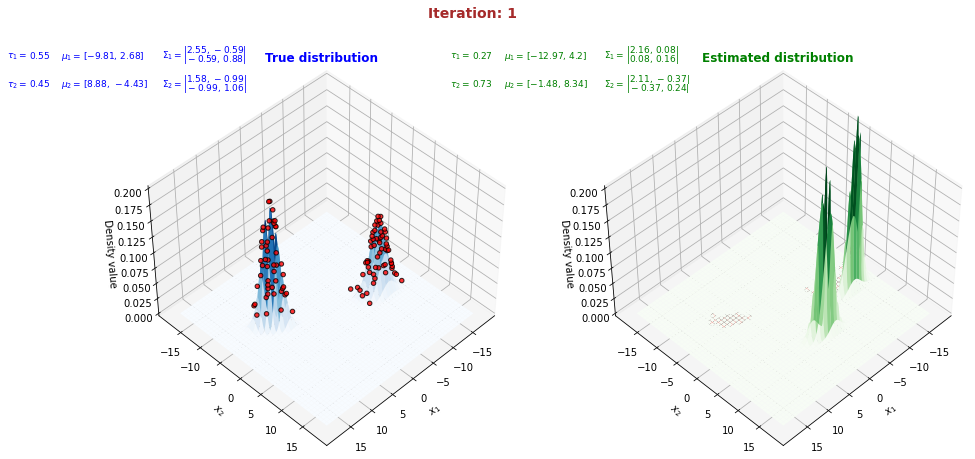

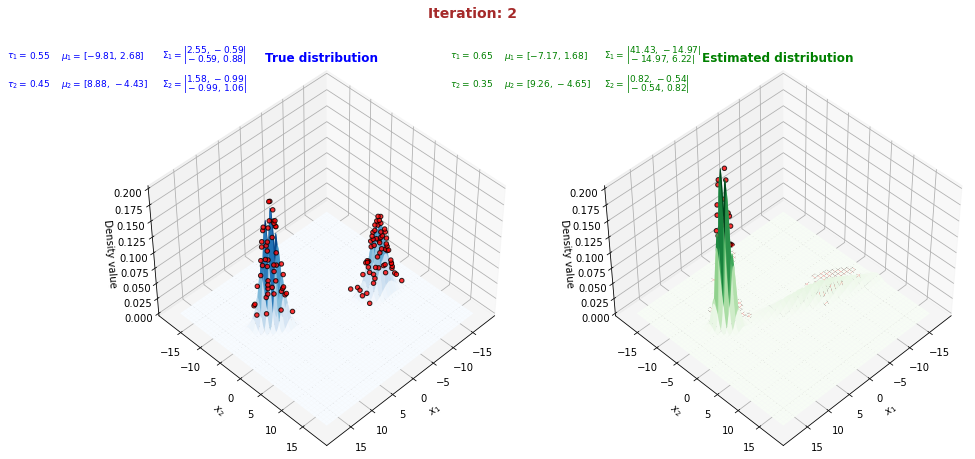

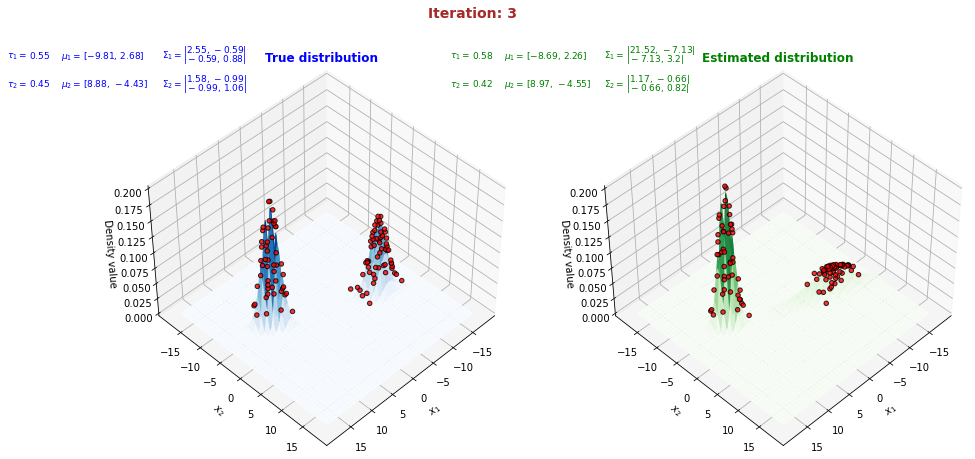

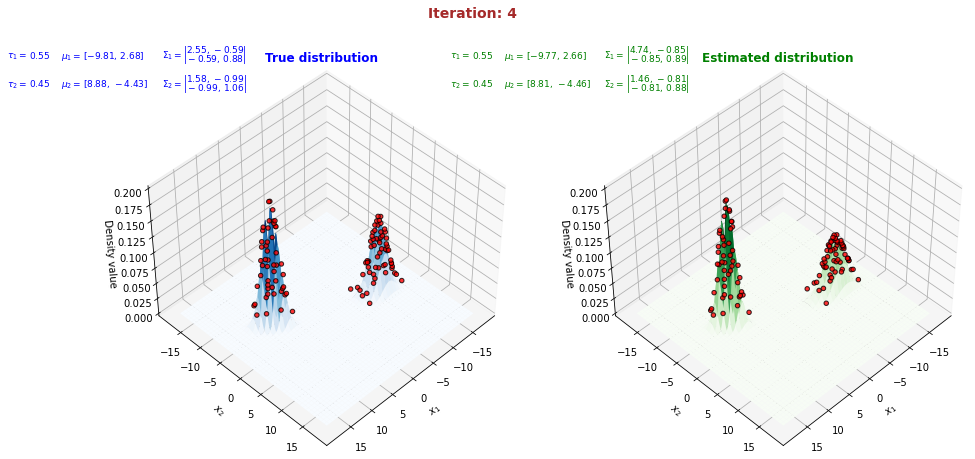

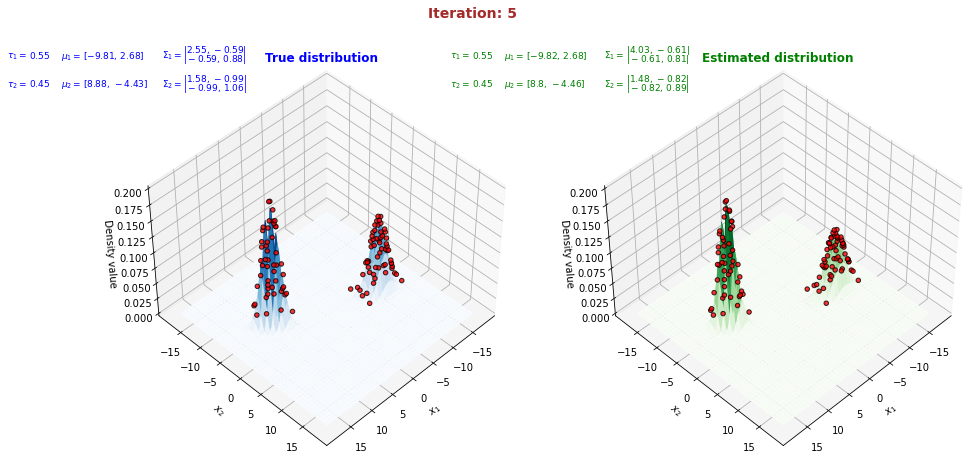

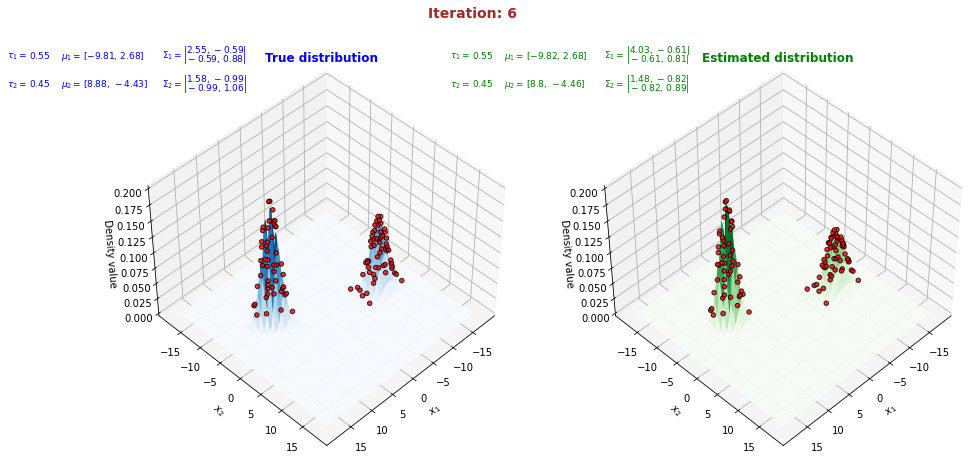

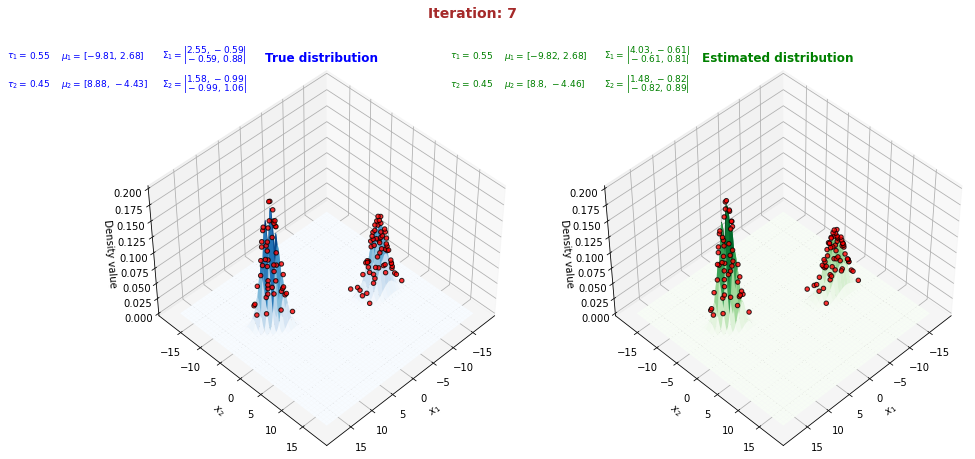

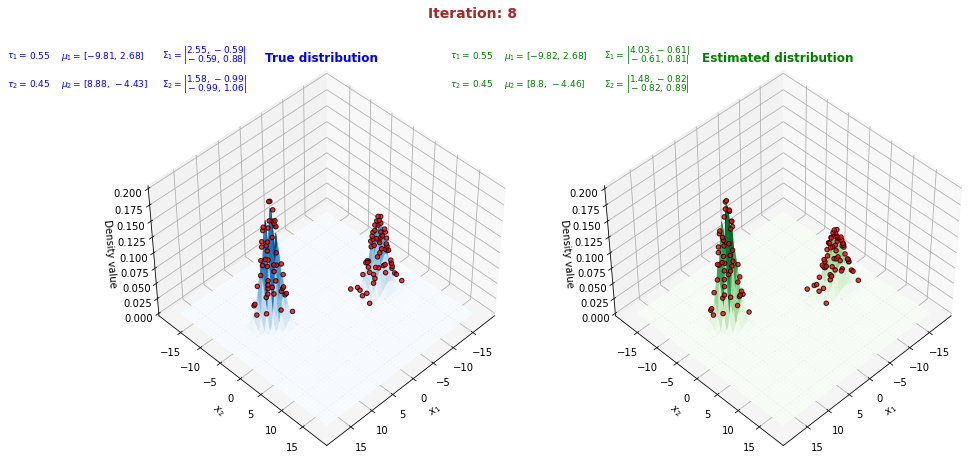

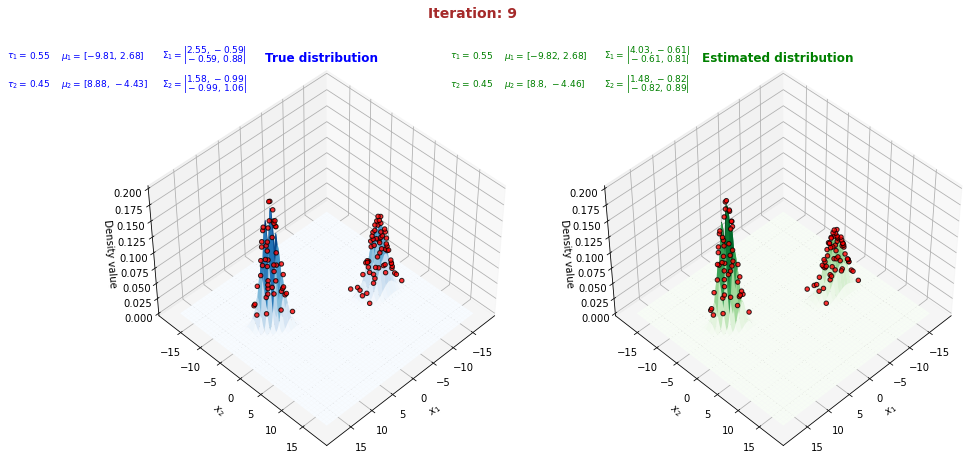

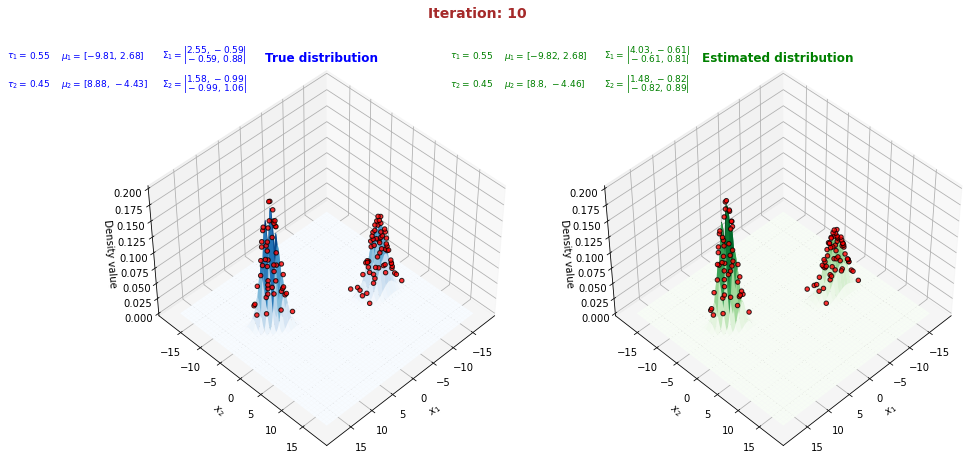

In [1]:
# -*- coding: utf-8 -*-
"""
Expectation Maximization for Gaussian mixture model. Example implementation of 
the theoretical results provided in the tutorial. 

Author: Jonne Pohjankukka 2021

Disclaimer: the code stability is subject to initial conditions and numerical issues, which need to tackled in the future.
The provided GIF-animation example however illustrates that the corresponding code and the EM-algorithm indeed works. 

"""

# Import necessary librariers.
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib import cm
warnings.filterwarnings('ignore')
from sklearn.datasets import make_spd_matrix
import random

# Smallest differentiable value of the system
EPS_VALUE = np.finfo(float).eps

"""
This function checks whether the provided matrix is symmetric positive definite, 
and if it is not, the function adds small value to the diagonal line of the matrix
until it is sym-pos-def. 
"""
def checkMatrixForSymPosDef(matrix): 
    # First we check that the matrix is symmetrix and positive definite
    if np.allclose(matrix, matrix.T) and np.all(np.linalg.eigvals(matrix) > 0):
        return matrix # All good, the matrix satisfies requirements
    else:
        # If it is not, we keep adding small increments to the diagonal elements of the matrix to make it sym-pos-def and return
        while (np.allclose(matrix, matrix.T) and np.all(np.linalg.eigvals(matrix) > 0)) == False:
            matrix += np.eye(matrix.shape[0])*0.1
        return matrix

"""
This function returns the density value of the provided Gaussian density function at a given x input
"""
def gaussianpdf(mu, sigma, x):    
    sigma = checkMatrixForSymPosDef(sigma) # Make sure the matrix is sym-pos-def
    const = 1.0/np.sqrt(np.power(2*np.pi, len(mu)) * np.linalg.det(sigma))
    pdf_value = const * np.exp(-1/2 * np.dot(np.transpose(x-mu), np.dot(np.linalg.inv(sigma), x-mu)))
    return pdf_value

"""
This function returns the density value of the provided Gaussian density function at a grid of x inputs
"""
def gaussianpdfgrid(mu, sigma, grid):
    n_dims = mu.shape[0]
    sigma = checkMatrixForSymPosDef(sigma) # Make sure the matrix is sym-pos-def
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N = np.sqrt((2*np.pi)**n_dims * sigma_det)
    pdfgrid = np.einsum('...k,kl,...l->...', grid-mu, sigma_inv, grid-mu)
    return np.exp(-pdfgrid / 2) / N

"""
This function returns the membership value of a given data point p(y = j|x, theta_t)
"""
# p(y = j|x,theta_t)
def membershipValue(mus, covs, taus, x, j):
    gaus_j = gaussianpdf(mus[:,j], covs[:,:,j], x) * taus[j]
    gaus_sum = 0
    for i in range(len(taus)):
        gaus_sum += gaussianpdf(mus[:,i], covs[:,:,i], x) * taus[i]
    membership_prob = gaus_j / float(gaus_sum)
    return membership_prob

"""
This function returns a random set of mixing tau parameters to be used for initial guess
"""
def createRandomTaus(number_of_clusters):
    taus = []
    for i in range(number_of_clusters):
        if i == number_of_clusters-1:
            taus.append(1-np.sum(taus))
        else:
            tau = random.uniform(0, 1-np.sum(taus))
            taus.append(tau)
    return taus

"""
This function returns random Gaussian parameters 
"""
def createRandomGaussianParams(number_of_dimensions, number_of_clusters, mu_limits):
    mus = np.zeros((number_of_dimensions, number_of_clusters))
    covs = np.zeros((number_of_dimensions, number_of_dimensions, number_of_clusters))
    for i in range(number_of_clusters):
        mu = np.random.uniform(mu_limits[0], mu_limits[1], size=(number_of_dimensions, 1))
        mus[:,i] = mu[:,0]
        covs[:,:,i] =  make_spd_matrix(number_of_dimensions, random_state=None)
    return mus, covs

"""
This function returns random samples from the given Gaussians 
"""
def createSamples(mus, covs, sample_counts):
    samples = []
    for i in range(len(sample_counts)):
        sample = np.random.multivariate_normal(mus[:,i], covs[:,:,i],size=sample_counts[i])
        samples.append(sample)
    return samples

"""
This function returns a list of Gaussian mixture parameters based on relative data sample sizes. 
The parameters (taus) sum into 1. 
"""
def createTaus(sample_counts):
    taus = []
    for i in range(len(sample_counts)):
        taus.append(sample_counts[i]/float(np.sum(sample_counts)))
    return taus

"""
This function plots Gaussian parameters into the figures
"""
def paramsToPlot(x, y, mus, covs, taus, fontcolor):
    text_space = 0.02
    mu_space = 0.05
    cov_space = 0.143
    fontsize = 9
    for cluster_ind in range(covs.shape[2]):
        c = 0.05*cluster_ind # For separating different Gaussian parameters
        # The taus
        plt.gcf().text(x, y-c, r'$\tau_'+str(cluster_ind+1)+'=$', fontsize=fontsize, color=fontcolor)
        plt.gcf().text(x+text_space, y-c, r'$'+str(np.round(taus[cluster_ind],2))+r'$', fontsize=fontsize, color=fontcolor)
        # The means
        plt.gcf().text(x+mu_space, y-c, r'$\mu_'+str(cluster_ind+1)+'=$', fontsize=fontsize, color=fontcolor)
        plt.gcf().text(x+mu_space+text_space, y-c, r'$\left['+str(np.round(mus[0,cluster_ind],2))+r',\,'+str(np.round(mus[1,cluster_ind],2))+r'\right]$', fontsize=fontsize, color=fontcolor)        
        # The sigmas
        plt.gcf().text(x+cov_space, y-c, r'$\Sigma_'+str(cluster_ind+1)+'=$', fontsize=fontsize, color=fontcolor)
        plt.gcf().text(x+cov_space+text_space, y+0.01-c, r'$\left|'+str(np.round(covs[0,0,cluster_ind],2))+r',\,'+str(np.round(covs[0,1,cluster_ind],2))+r'\right|$', fontsize=fontsize, color=fontcolor)
        plt.gcf().text(x++cov_space+text_space, y-0.006-c, r'$\left|'+str(np.round(covs[1,0,cluster_ind],2))+r',\,'+str(np.round(covs[1,1,cluster_ind],2))+r'\right|$', fontsize=fontsize, color=fontcolor)

"""
This function creates an illustrative plot of the EM-algorithm lifecycle iteration by iteration
"""
def plotGaussians(true_mus, true_covs, true_taus, est_mus, est_covs, est_taus, mu_limits, iteration, dataset):
    # Create the plot grid
    N = 300
    plotdiff = 3
    X = np.linspace(mu_limits[0]-plotdiff, mu_limits[1]+plotdiff, N)
    Y = np.linspace(mu_limits[0]-plotdiff, mu_limits[1]+plotdiff, N)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    # Next we calculate the surfaces
    true_Z = 0.0
    est_Z = 0.0
    for dimension_ind in range(0, true_mus.shape[1]): # Go through all Gaussians
        true_Z += gaussianpdfgrid(true_mus[:,dimension_ind], true_covs[:,:,dimension_ind], pos)
        est_Z += gaussianpdfgrid(est_mus[:,dimension_ind], est_covs[:,:,dimension_ind], pos)
    # Calculate the density values of the data points
    data_Z_true = np.zeros((dataset.shape[0],1))+0.01
    data_Z_est = np.zeros((dataset.shape[0],1))+0.01
    for data_ind in range(dataset.shape[0]):
        for dimension_ind in range(0, true_mus.shape[1]):
            data_Z_true[data_ind] += gaussianpdf(true_mus[:,dimension_ind], true_covs[:,:,dimension_ind], dataset[data_ind, :])
            data_Z_est[data_ind] += gaussianpdf(est_mus[:,dimension_ind], est_covs[:,:,dimension_ind], dataset[data_ind, :])
    # Create the plots
    fig = plt.figure(figsize=(15,8))
    # True distribution plot
    ax1 = fig.add_subplot(1,2,1,projection='3d')
    ax1.plot_surface(X, Y, true_Z, cmap=cm.Blues, alpha=1, linewidth=0)
    ax1.view_init(45,45)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_zlabel('Density value')
    ax1.set_title("True distribution", color="blue", fontweight="bold")
    ax1.scatter(dataset[:,0], dataset[:,1], data_Z_true, color="red", alpha=0.8, edgecolor='black', linewidths=1)
    ax1.set_zlim(0, 0.2)
    paramsToPlot(0.01, 0.85, true_mus, true_covs, true_taus, "blue")
    # Estimated distribution plot
    ax2 = fig.add_subplot(1,2,2,projection='3d')
    ax2.plot_surface(X, Y, est_Z, cmap=cm.Greens, alpha=1, linewidth=0)
    ax2.scatter(dataset[:,0], dataset[:,1], data_Z_est, color="red", alpha=0.8, edgecolor='black', linewidths=1)
    ax2.view_init(45,45)
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel(r'$x_2$')
    ax2.set_zlabel('Density value')
    ax2.set_title("Estimated distribution", color="green", fontweight="bold")
    ax2.set_zlim(0, 0.2)
    paramsToPlot(0.42, 0.85, est_mus, est_covs, est_taus, "green")
    # Set the plot title
    plt.gcf().text(0.4, 0.92, "Iteration: " + str(iteration), fontsize=14, fontweight="bold", color="brown")
    
"""
This function implements the EM-algorithm's one update iteration
"""
def updateParameters(mus, covs, taus, dataset):
    mus_new = np.copy(mus)
    covs_new = np.copy(covs)
    taus_new = np.copy(taus)
    for k in range(0, len(taus)): # We update all of the k Gaussians
        # First taus
        membership_sum = 0.0
        for j in range(0, dataset.shape[0]): # Loop all data points
            membership_sum += membershipValue(mus, covs, taus, dataset[j,:], k)
        taus_new[k] = membership_sum / float(dataset.shape[0])
        # Now means
        mean_value = np.array([0.0,0.0])
        for j in range(0, dataset.shape[0]):
            mean_value += membershipValue(mus, covs, taus, dataset[j,:], k) * dataset[j, :]
        mus_new[:,k] = np.transpose(mean_value / membership_sum)
        # Now covariance
        cov_sum = np.zeros(shape=covs[:,:,0].shape)
        for j in range(0, dataset.shape[0]):
            x_minus_u_col = np.array(np.transpose(dataset[j,:]) - mus_new[:,k])
            x_minus_u_row = np.transpose(x_minus_u_col)
            cov_sum += membershipValue(mus, covs, taus, dataset[j,:], k) * np.outer(x_minus_u_row, x_minus_u_row)
        covs_new[:,:,k] = checkMatrixForSymPosDef(cov_sum / membership_sum)
    return mus_new, covs_new, taus_new
        
######################################################
""" 

**** EXAMPLE RUN: 2-Gaussian mixture model ****

Disclaimer: due to numerical instability issues, you might need
to try the code couple of times to get a good visualization. 


"""
######################################################
# Create the true Gaussians
mu_limits = [-15, 15]
number_of_dimensions = 2 # This parameter is fixed to 2 for the moment
number_of_clusters = 2 # How many Gaussians, can be altered
true_mus, true_covs = createRandomGaussianParams(number_of_dimensions, number_of_clusters, mu_limits)
# Make the random samples from the Gaussians
sample_counts = [60, 50]
samples = createSamples(true_mus, true_covs, sample_counts)
# Make true mixture parameters based on the relative samples sizes 
true_taus = createTaus(sample_counts)
# Make random starting Gaussians
est_mus, est_covs = createRandomGaussianParams(number_of_dimensions, number_of_clusters, mu_limits)
est_taus = createRandomTaus(number_of_clusters)
# Put the dataset into single matrix and shuffle the data points
dataset = np.concatenate(samples, axis=0)
np.random.shuffle(dataset)
# Implement the Expectation-Maximizatrion iterations
number_of_EM_iterations = 10
for i in range(number_of_EM_iterations):
    print("**** EXPECTATION-MAXIMIZATION TRAINING ITERATION: " + str(i+1) + "/" + str(number_of_EM_iterations) +" ****")
    plotGaussians(true_mus, true_covs, true_taus, est_mus, est_covs, est_taus, mu_limits, i+1, dataset)
    est_mus, est_covs, est_taus = updateParameters(est_mus, est_covs, est_taus, dataset)

